<a href="https://colab.research.google.com/github/pgbio99/Study_Gene-Expression_-Chemoresistance-in-Cancer_Machine-learning/blob/main/RF_drug_response_phenotype_sensitive__vs_resistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GSE11440_series_matrix_clean.csv to GSE11440_series_matrix_clean.csv
Saving GSE15709-GPL570_series_matrix_clean.csv to GSE15709-GPL570_series_matrix_clean.csv
Saving GSE26459_series_matrix_clean.csv to GSE26459_series_matrix_clean.csv
Saving GSE27473_series_matrix_clean.csv to GSE27473_series_matrix_clean.csv
Saving GSE69657_series_matrix_clean.csv to GSE69657_series_matrix_clean.csv
Saving Master_Union_Biomarkers_N.csv to Master_Union_Biomarkers_N.csv
Saving phen_data_15709.csv to phen_data_15709.csv
Saving phen_data_26459.csv to phen_data_26459.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving phen_data_27473.csv to phen_data_27473.csv
Saving phen_data_69657.csv to phen_data_69657.csv
Saving phenotype data_11440.csv to phenotype data_11440.csv


In [ ]:
Master_filepath = 'Master_Union_Biomarkers_N.csv'

Expression_files = [
    'GSE11440_series_matrix_clean.csv',
    'GSE15709-GPL570_series_matrix_clean.csv',
    'GSE26459_series_matrix_clean.csv',
    'GSE27473_series_matrix_clean.csv',
    'GSE69657_series_matrix_clean.csv',
]

Label_filepath = [
    'phenotype data_11440.csv',
    'phen_data_15709.csv',
    'phen_data_26459.csv',
    'phen_data_27473.csv',
    'phen_data_69657.csv',
]

In [ ]:
Top_N_Features = 50
Output_fea_file = 'Predictive_Features.csv'

In [ ]:
import io

def clean_index_names(df):
    """Aggressively cleans index and column names by stripping quotes, spaces, and carriage returns."""
    df.index = df.index.astype(str).str.strip().str.replace('"', '').str.replace('\r', '')
    df.columns = df.columns.astype(str).str.strip().str.replace('"', '').str.replace('\r', '')
    return df

def normalize_sample_ids(index):
    """Strips common GEO prefixes/suffixes to standardize sample IDs for matching."""
    index = index.astype(str).str.strip().str.replace('"', '').str.replace('\r', '')

    index = index.str.replace(r'^(GSM|SAM|GSE)\s*', '', regex=True, case=False)
    index = index.str.replace(r'\.(CEL|TXT|GZ)$', '', regex=True, case=False)

    return index.str.strip()

def load_and_clean_exp_data(exp_path):
    """Loads expression data with aggressive cleaning and transposition check."""
    df_exp = None
    try:
        with open(exp_path, 'r') as f:
            content = f.read()
        content = content.replace('"', '').replace('\r', '')

        df_exp = pd.read_csv(io.StringIO(content), index_col=0, sep=None, engine='python')

    except FileNotFoundError:
        raise
    except Exception as e:
        print(f"Fallback read failure for {exp_path}: {e}")
        return None

    if df_exp is not None and df_exp.shape[0] > df_exp.shape[1]:
        df_exp = df_exp.T

    if df_exp is not None:
        df_exp = clean_index_names(df_exp)
        df_exp.index = normalize_sample_ids(df_exp.index)

    return df_exp

def load_label_data(label_path):
    """Loads label data with robust index cleaning and column renaming."""
    df_label = None
    try:
        df_label = pd.read_csv(label_path, index_col=0, sep=None, engine='python')
    except FileNotFoundError:
        raise
    except Exception as e:
        print(f"Label fallback read failure for {label_path}: {e}")
        return None

    if df_label is None: return None

    df_label = clean_index_names(df_label)
    df_label.index = normalize_sample_ids(df_label.index)

    if 'Label' not in df_label.columns and len(df_label.columns) > 0:
        first_col = df_label.columns[0]
        df_label.rename(columns={first_col: 'Label'}, inplace=True)

    if 'Label' in df_label.columns:
        return df_label
    else:
        if len(df_label.columns) == 1 and df_label.columns[0] != 'Label':
            df_label.rename(columns={df_label.columns[0]: 'Label'}, inplace=True)
            return df_label
        return None

In [ ]:
print("--- Data Consolidation and Setup ---")

try:
    master_df = pd.read_csv(Master_filepath)
    if 'Gene' not in master_df.columns:
         master_df.rename(columns={master_df.columns[0]: 'Gene'}, inplace=True)
    master_probe_ids = set(master_df['Gene'].astype(str).str.strip().tolist())
    print(f"Loaded Master Gene list with {len(master_probe_ids)} unique probes.")
except Exception as e:
    print(f"Error loading Master Gene List: {e}. Cannot proceed without master list.")
    raise ValueError("Master Gene List Error")

combined_exp_list = []
combined_label_list = []

for exp_path, label_path in zip(Expression_files, Label_filepath):
    study_name = os.path.basename(exp_path).split('_')[0]
    try:
        exp_df = load_and_clean_exp_data(exp_path)
        label_df = load_label_data(label_path)

        if exp_df is None or label_df is None:
            print(f"Skipping study {study_name}: Failed to load/parse {os.path.basename(exp_path)} or {os.path.basename(label_path)}.")
            continue

        common_samples = exp_df.index.intersection(label_df.index)

        if len(common_samples) == 0:
            print(f"Skipping study {study_name}: No common samples found (0 samples) between {os.path.basename(exp_path)} and {os.path.basename(label_path)}.")
            continue

        exp_df = exp_df.loc[common_samples]
        label_df = label_df.loc[common_samples]

        combined_exp_list.append(exp_df)
        combined_label_list.append(label_df)

        print(f"Successfully included study data for {study_name} ({len(exp_df)} samples)")

    except FileNotFoundError:
        print(f"Skipping study {study_name}: **CRITICAL: Required file not found.** Please verify the file name and re-upload the missing one from the pair: {exp_path} or {label_path}")
        continue
    except Exception as e:
        print(f"Skipping study {study_name}: General processing error for {exp_path}. Error: {e}")
        continue

if len(combined_exp_list) == 0:
    print("\n---------------------------------------------------------------")
    print("CRITICAL ERROR: No data objects to concatenate.")
    print("This means all files failed to load/align. Please check file formats/content.")
    print("---------------------------------------------------------------")
    raise ValueError("No data loaded. Stopping script.")

X_combined = pd.concat(combined_exp_list, axis=0)
Y_combined = pd.concat(combined_label_list, axis=0)['Label']

label_map = None
if Y_combined.dtype == 'object':
    unique_labels = Y_combined.unique()
    unique_labels.sort()
    label_map = {label: i for i, label in enumerate(unique_labels)}
    Y_combined = Y_combined.map(label_map)
    print(f"Converted string labels to numeric: {label_map}")
    plot_labels = list(label_map.keys())
else:
     plot_labels = ['Class 0', 'Class 1']


print(f"Total Consolidated Samples (Rows): {X_combined.shape[0]}")

--- Data Consolidation and Setup ---
Loaded Master Gene list with 298 unique probes.
Successfully included study data for GSE11440 (6 samples)
Successfully included study data for GSE15709-GPL570 (10 samples)
Successfully included study data for GSE26459 (24 samples)
Successfully included study data for GSE27473 (6 samples)
Successfully included study data for GSE69657 (30 samples)
Converted string labels to numeric: {'Resistant': 0, 'Sensitive': 1}
Total Consolidated Samples (Rows): 76


In [ ]:
initial_probes = set(X_combined.columns)
final_probes_for_ml = list(master_probe_ids.intersection(initial_probes))

if len(final_probes_for_ml) == 0:
    print("\nCRITICAL ERROR: No common features between Master List and Expression data. Check Probe IDs.")
    raise ValueError("No common features. Stopping script.")


X_filtered = X_combined[final_probes_for_ml]
X_filtered = X_filtered.apply(pd.to_numeric, errors='coerce')
X_filtered = X_filtered.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

Y_combined = Y_combined.loc[X_filtered.index]

print(f"Data Filtered to Master Features (Columns): {X_filtered.shape[1]}")
print(f"Final Samples after NaN removal: {X_filtered.shape[0]}")

if X_filtered.shape[0] == 0:
    print("\nCRITICAL ERROR: All samples dropped due to missing data. Cannot proceed.")
    raise ValueError("No samples remaining after cleaning.")

if len(Y_combined.unique()) < 2:
    print("\nCRITICAL ERROR: Only one class remaining after cleaning. Cannot train classifier.")
    print(f"Remaining Labels: {Y_combined.unique()}")
    raise ValueError("Single class remaining. Cannot proceed.")

try:
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_filtered,
        Y_combined,
        test_size=0.2,
        random_state=42,
        stratify=Y_combined
    )
except:
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_filtered,
        Y_combined,
        test_size=0.2,
        random_state=42
    )

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data Filtered to Master Features (Columns): 298
Final Samples after NaN removal: 76
X_train shape: (60, 298)
X_test shape: (16, 298)


In [ ]:
print("\n--- Random Forest Training and Validation ---")

rf_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)
Y_proba = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(Y_test, Y_pred)
auc_roc = roc_auc_score(Y_test, Y_proba)

print(f"Model Accuracy on Test Set: {accuracy:.4f}")
print(f"AUC-ROC Score: {auc_roc:.4f}")
print("\nClassification Report (Precision, Recall, F1-Score):")
print(classification_report(Y_test, Y_pred))


--- Random Forest Training and Validation ---
Model Accuracy on Test Set: 0.8750
AUC-ROC Score: 0.9219

Classification Report (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [ ]:
def plot_auc_roc_curve(y_test, y_proba, auc_score):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right"); plt.show(); plt.savefig('ROC_AUC_Curve.png'); plt.close()

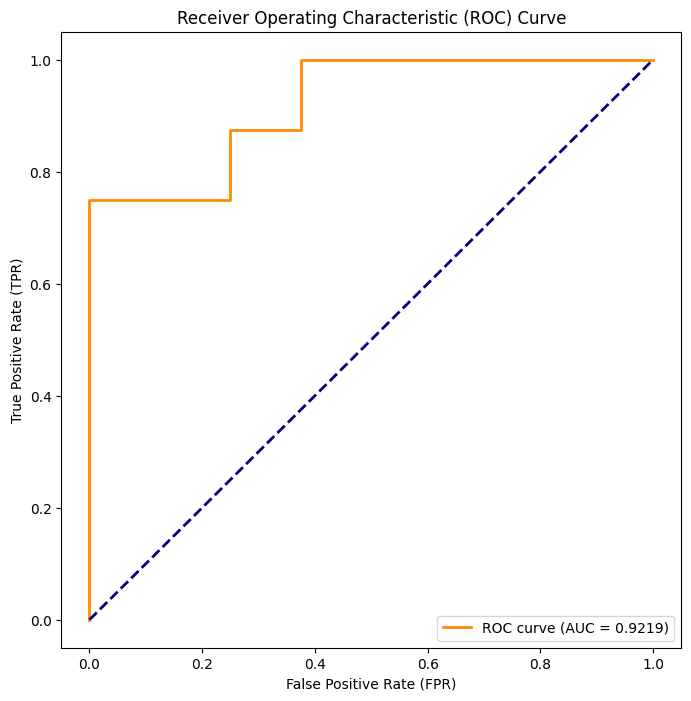

In [ ]:
plot_auc_roc_curve(Y_test, Y_proba, auc_roc)

In [ ]:
def plot_confusion_matrix_heatmap(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix Heatmap'); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()
    plt.savefig('Confusion_Matrix_Heatmap.png'); plt.close()

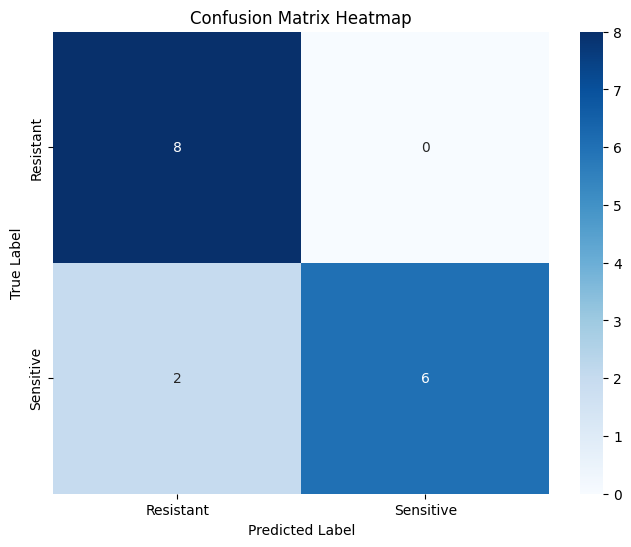

In [ ]:
plot_confusion_matrix_heatmap(Y_test, Y_pred, plot_labels)

In [ ]:
print("\n--- Feature Importance Ranking (Select Final Biomarkers) ---")

importances = rf_model.feature_importances_
feature_names = X_filtered.columns

feature_importance_df = pd.DataFrame({
    'Probe_ID': feature_names,
    'Importance': importances
})

top_features_df = feature_importance_df.sort_values(
    by='Importance',
    ascending=False
).head(Top_N_Features)

top_features_df.to_csv(Output_fea_file, index=False)

print(f"\nSuccessfully identified and saved {Top_N_Features} predictive biomarkers to {Output_fea_file}.")
print(f"Top 5 Feature Importances (Probe IDs):")
print(top_features_df.head(5))


--- Feature Importance Ranking (Select Final Biomarkers) ---

Successfully identified and saved 50 predictive biomarkers to Predictive_Features.csv.
Top 5 Feature Importances (Probe IDs):
        Probe_ID  Importance
212    1007_s_at    0.021455
240  201029_s_at    0.017828
40     200872_at    0.015259
177  208579_x_at    0.013885
296    218450_at    0.013663


In [ ]:
def plot_feature_importance(df, n=20):
    df_plot = df.rename(columns={'Probe_ID': 'Feature_ID'}).head(n).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(df_plot['Feature_ID'], df_plot['Importance'], color='skyblue')
    plt.xlabel('Feature Importance (Gini Index)')
    plt.title(f'Top {n} Predictive Biomarkers by Random Forest')
    plt.tight_layout(); plt.show(); plt.savefig('Top_Features_Bar_Chart.png'); plt.close()

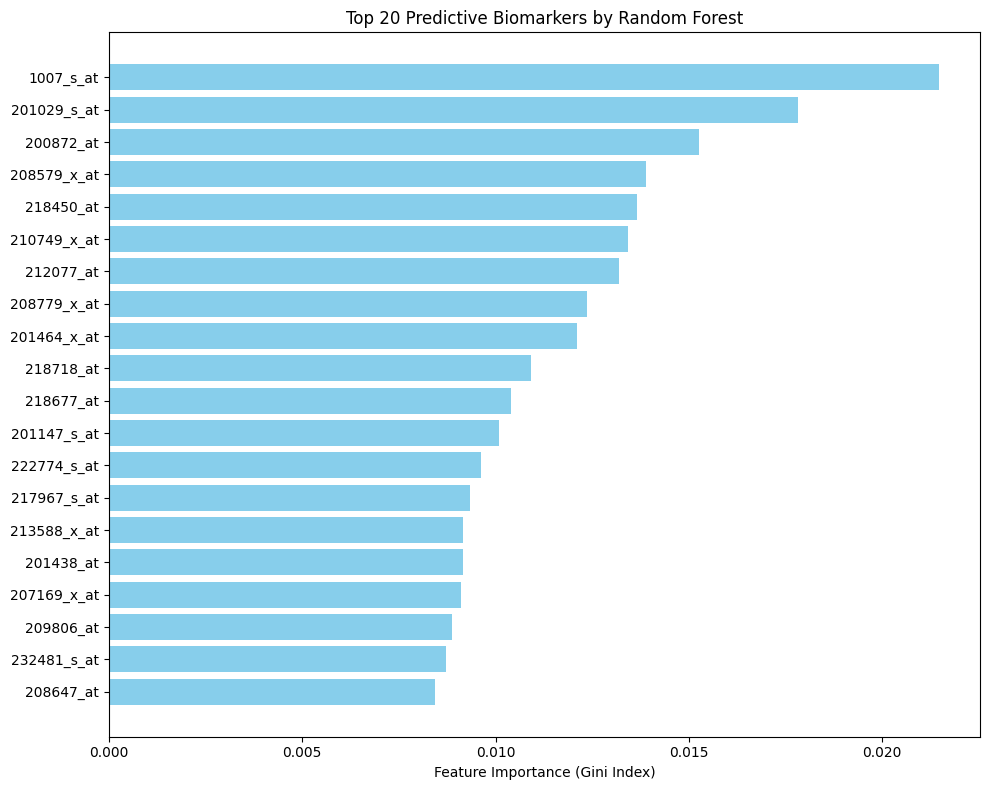

In [ ]:
plot_feature_importance(top_features_df, n=20)